<a href="https://www.kaggle.com/code/saraezati/notebook36afd07425?scriptVersionId=231592656" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [18]:
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import cv2
import joblib
import seaborn as sns
import hashlib
import xgboost as xgb
import cupy as cp  # To ensure GPU computation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from skimage.feature import local_binary_pattern



In [19]:
torch.manual_seed(42)
np.random.seed(42)

In [20]:
DATASET_PATH = "/kaggle/input/training/Training"
DATASET_PATH_TEST = "/kaggle/input/testing/Museum_Validation"

In [21]:
def image_hash(image):
    """Generate a hash for an image to detect duplicates."""
    return hashlib.md5(image.tobytes()).hexdigest()

In [22]:
def preprocess_images(dataset_path):
    labels = []
    features = []
    brightness_values = []
    edge_densities = []
    seen_hashes = set()  # Track seen images to remove duplicates

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)

        if not os.path.isdir(category_path):
            continue

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)

            # Skip corrupt or unreadable images
            if image is None:
                print(f"Warning: Skipping unreadable image {image_path}")
                continue

            # Resize image
            image = cv2.resize(image, (128, 128))

            # Check for duplicate images
            img_hash = image_hash(image)
            if img_hash in seen_hashes:
                print(f"Skipping duplicate image: {image_path}")
                continue
            seen_hashes.add(img_hash)

            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Compute brightness (normalized)
            brightness = np.mean(image) / 255.0  # Scale to [0,1]
            brightness_values.append(brightness)

            # Compute edge density (normalized)
            edges = cv2.Canny(gray, 100, 200)
            edge_density = np.sum(edges) / (image.size * 255.0)  # Scale to [0,1]
            edge_densities.append(edge_density)

            # Extract features
            color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform").flatten()
            hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

            # Combine all features
            feature_vector = np.hstack([color_hist, lbp, hog_features, brightness, edge_density])
            features.append(feature_vector)

            # Assign label: 0 for Indoor, 1 for Outdoor
            labels.append(0 if category.lower() == "museum-indoor" else 1)

    # Convert lists to numpy arrays
    X = np.array(features)
    y = np.array(labels)

    # Standardize features (for better ML performance)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Print class distribution
    class_counts = Counter(y)
    print("Class distribution:", class_counts)

    return X, y, brightness_values, edge_densities



In [23]:
# Preprocess images and extract features
X, y, brightness_values, edge_densities = preprocess_images(DATASET_PATH)

Skipping duplicate image: /kaggle/input/training/Training/museum-outdoor/00001121.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00001569.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00000289.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00000635.jpg
Class distribution: Counter({1: 4999, 0: 4997})


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

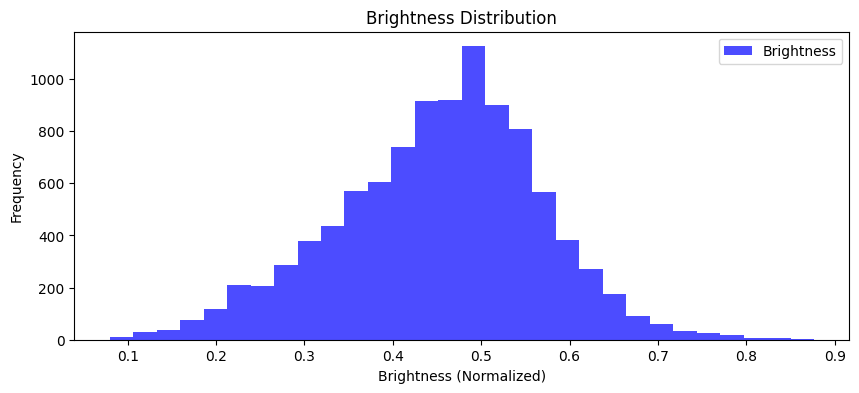

In [24]:
# EDA Visualizations
plt.figure(figsize=(10, 4))
plt.hist(brightness_values, bins=30, color='blue', alpha=0.7, label='Brightness')
plt.xlabel("Brightness (Normalized)")
plt.ylabel("Frequency")
plt.title("Brightness Distribution")
plt.legend()
plt.show()

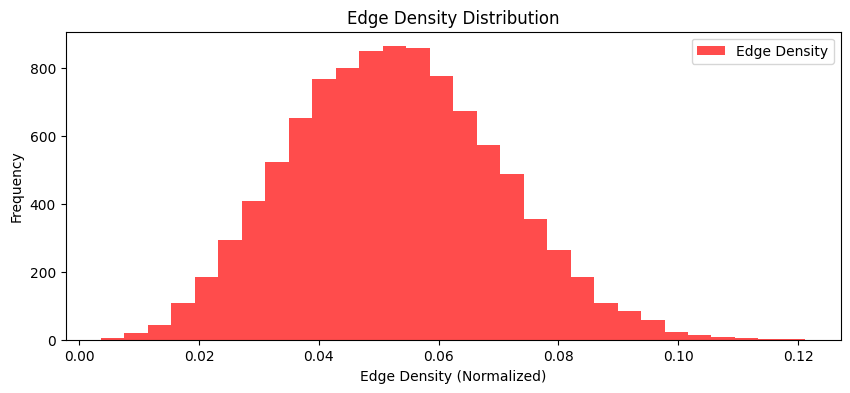

In [25]:
plt.figure(figsize=(10, 4))
plt.hist(edge_densities, bins=30, color='red', alpha=0.7, label='Edge Density')
plt.xlabel("Edge Density (Normalized)")
plt.ylabel("Frequency")
plt.title("Edge Density Distribution")
plt.legend()
plt.show()

In [ ]:
def display_sample_images(dataset_path, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    class_labels = ["Indoor", "Outdoor"]

    for i, category in enumerate(os.listdir(dataset_path)):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue

        images = [img for img in os.listdir(category_path)][:num_samples]
        for j, image_name in enumerate(images):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))  # Resize for consistency
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.equalizeHist(gray)  # Apply histogram equalization

            axes[i, j].imshow(gray, cmap="gray")
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{class_labels[i]} {j+1}")

    plt.suptitle("Sample Preprocessed Images from Each Class")
    plt.show()

In [ ]:
# Function: Train and Evaluate Model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n🔹 Results for {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save model
    joblib.dump(model, f"{model_name}.pkl")

In [ ]:
# Hyperparameter Tuning Function
def tune_hyperparameters(model, param_grid, X_train, y_train, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [ ]:
# 1. Train Decision Tree with Hyperparameter Tuning
dt_param_grid = {
    'max_depth': [5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10]
}
best_dt = tune_hyperparameters(DecisionTreeClassifier(random_state=42), dt_param_grid, X_train, y_train, "DecisionTree")
train_and_evaluate_model(best_dt, X_train, y_train, X_test, y_test, "DecisionTree")


In [ ]:
# 2. Train Random Forest with Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
best_rf = tune_hyperparameters(RandomForestClassifier(random_state=42), rf_param_grid, X_train, y_train, "RandomForest")
train_and_evaluate_model(best_rf, X_train, y_train, X_test, y_test, "RandomForest")

In [ ]:
# 3. Train XGB with Hyperparameter Tuning

# Move Data to GPU to Fix the Warning
def convert_to_dmatrix(X, y):
    return xgb.DMatrix(X, label=y, enable_categorical=True)  # Efficient memory use

# Hyperparameter Tuning with Safer Memory Management
def tune_hyperparameters_gpu(X_train, y_train, param_distributions, n_iter=10):
    xgb_model = xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', random_state=42,
        tree_method="hist", device="cuda", grow_policy="lossguide", max_bin=256
    )

    random_search = RandomizedSearchCV(
        xgb_model, param_distributions, n_iter=n_iter, cv=2, 
        n_jobs=1,  # FIX: Reduce memory pressure
        random_state=42
    )
    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    return random_search.best_estimator_

# Parameter Distributions (Optimized for Speed)
xgb_param_distributions = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.05, 0.1, 0.15],  
    'max_depth': [3, 4],  
    'subsample': [0.7, 0.8],  
    'colsample_bytree': [0.7, 0.8],  
    'gamma': [0, 0.1]
}

# Train and Evaluate (Fix Device Issue)
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # FIX: Convert Data to DMatrix and Move to GPU
    dtrain = convert_to_dmatrix(X_train, y_train)
    dtest = convert_to_dmatrix(X_test, y_test)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    print(f"\n🔹 Results for {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save model
    joblib.dump(model, f"/kaggle/working/{model_name}.pkl")
    print(f"Model saved as {model_name}.pkl")

# Run Training with Fixes
best_xgb_gpu = tune_hyperparameters_gpu(X_train, y_train, xgb_param_distributions, n_iter=10)
train_and_evaluate_model(best_xgb_gpu, X_train, y_train, X_test, y_test, "XGB")

 



In [ ]:
# 4. Semi-Supervised Learning with Decision Tree
# Select only 20% labeled data, 80% unlabeled
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Train model on labeled data
semi_supervised_dt = DecisionTreeClassifier(max_depth=10, random_state=42)
semi_supervised_dt.fit(X_labeled, y_labeled)

In [ ]:
# Predict pseudo-labels for unlabeled data
pseudo_labels = semi_supervised_dt.predict(X_unlabeled)

# Select high-confidence predictions (probability >= 85%)
probabilities = semi_supervised_dt.predict_proba(X_unlabeled)
high_confidence = (probabilities.max(axis=1) >= 0.85)

X_high_confidence = X_unlabeled[high_confidence]
y_high_confidence = pseudo_labels[high_confidence]

# Add high-confidence pseudo-labels to training data
X_new_train = np.vstack((X_labeled, X_high_confidence))
y_new_train = np.hstack((y_labeled, y_high_confidence))

# Retrain model with expanded labeled dataset
semi_supervised_dt.fit(X_new_train, y_new_train)
train_and_evaluate_model(semi_supervised_dt, X_test, y_test, X_test, y_test, "SemiSupervisedDT")

In [26]:
# Load saved models
models = {
    "DecisionTree": joblib.load("/kaggle/input/training-models/scikitlearn/default/1/DecisionTree.pkl"),
    "RandomForest": joblib.load("/kaggle/input/training-models/scikitlearn/default/1/RandomForest.pkl"),
    "SemiSupervisedDT": joblib.load("/kaggle/input/training-models/scikitlearn/default/1/SemiSupervisedDT.pkl"),
    "XGBoost": joblib.load("/kaggle/input/xgb4/scikitlearn/v4/1/XGB.pkl")
}

In [27]:
def preprocess_test_images(dataset_path):
    labels = []
    features = []
    brightness_values = []
    edge_densities = []

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)

        if not os.path.isdir(category_path):
            continue

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Skipping unreadable image {image_path}")
                continue

            image = cv2.resize(image, (128, 128))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            brightness = np.mean(image) / 255.0
            brightness_values.append(brightness)

            edges = cv2.Canny(gray, 100, 200)
            edge_density = np.sum(edges) / (image.size * 255.0)
            edge_densities.append(edge_density)

            color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform").flatten()
            hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

            feature_vector = np.hstack([color_hist, lbp, hog_features, brightness, edge_density])
            features.append(feature_vector)

            labels.append(0 if category.lower() == "museum-indoor" else 1)

    X_test = np.array(features)
    y_test = np.array(labels)

    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    return X_test, y_test

# Preprocess test images
X_test, y_test = preprocess_test_images(DATASET_PATH_TEST)


🔹 Evaluating Model: DecisionTree
Accuracy: 0.7700
Classification Report:
               precision    recall  f1-score   support

      Indoor       0.75      0.80      0.78       100
     Outdoor       0.79      0.74      0.76       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200



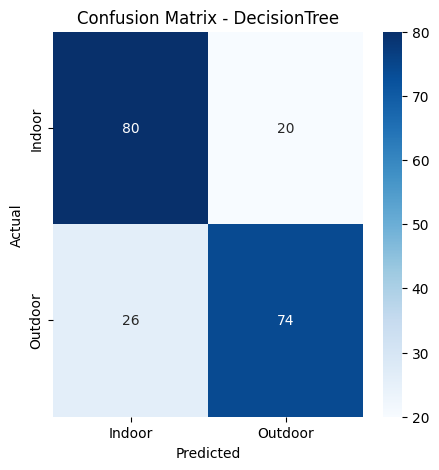


🔹 Evaluating Model: RandomForest
Accuracy: 0.8600
Classification Report:
               precision    recall  f1-score   support

      Indoor       0.85      0.88      0.86       100
     Outdoor       0.88      0.84      0.86       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



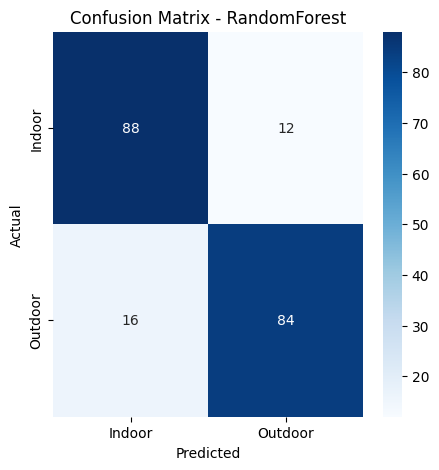


🔹 Evaluating Model: SemiSupervisedDT
Accuracy: 0.7600
Classification Report:
               precision    recall  f1-score   support

      Indoor       0.74      0.80      0.77       100
     Outdoor       0.78      0.72      0.75       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200



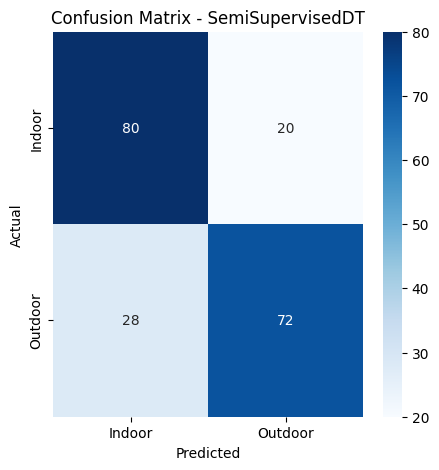


🔹 Evaluating Model: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:35:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9150
Classification Report:
               precision    recall  f1-score   support

      Indoor       0.92      0.91      0.91       100
     Outdoor       0.91      0.92      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



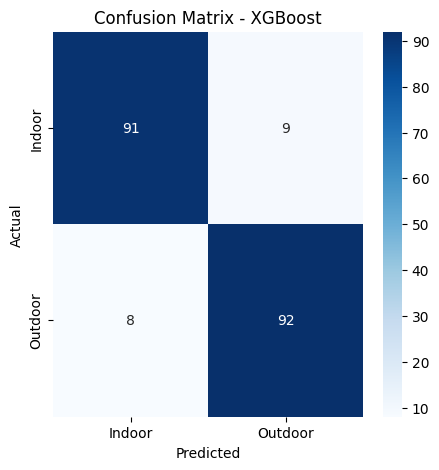

In [28]:
# Evaluate models
for model_name, model in models.items():
    print(f"\n🔹 Evaluating Model: {model_name}")
    
    # Predict on test dataset
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Indoor", "Outdoor"])
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    
    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Indoor", "Outdoor"], yticklabels=["Indoor", "Outdoor"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


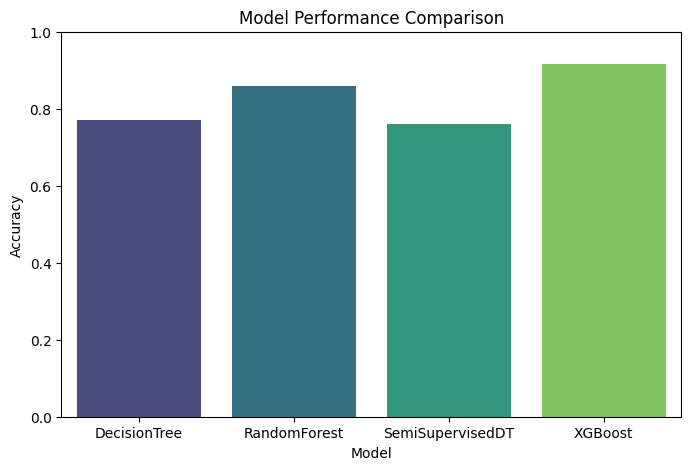

In [29]:
model_names = []
accuracies = []

# Store results for comparison
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    model_names.append(model_name)
    accuracies.append(accuracy)

# Plot model comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

In [30]:
# Define transformations for training data (with Augmentations)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
    transforms.RandomRotation(20),  # Rotate randomly within ±20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Change brightness, contrast, saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation/test data (NO augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [31]:
# Load full dataset (ONLY training data)
full_dataset = datasets.ImageFolder(root=DATASET_PATH)

# First split: 80% train+val, 20% test (matches Phase 1's test_size=0.2)
train_val_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_val_size
train_val_set, test_set = random_split(full_dataset, [train_val_size, test_size])

# Second split: 80% train, 20% val of the train_val_set
train_size = int(0.8 * len(train_val_set))
val_size = len(train_val_set) - train_size
train_set, val_set = random_split(train_val_set, [train_size, val_size])

# Apply test transforms to val and test sets
val_set.dataset.transform = test_transform
test_set.dataset.transform = test_transform

In [32]:
# Define DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Visualize augmented images
dataloader = DataLoader(train_set, batch_size=8, shuffle=True)
images, labels = next(iter(dataloader))
# Print dataset sizes
print(f"Training set: {len(train_set)} images")
print(f"Validation set: {len(val_set)} images")
print(f"Test set: {len(test_set)} images")

Training set: 6400 images
Validation set: 1600 images
Test set: 2000 images


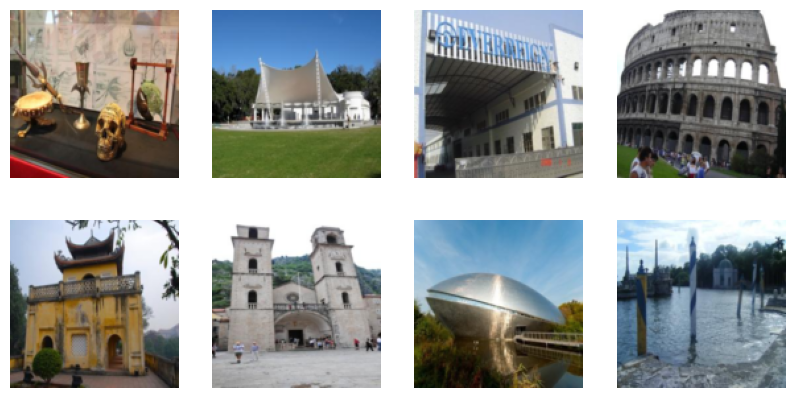

In [33]:
def show_images(images):
    images = images.numpy().transpose(0, 2, 3, 1)  # Convert tensor to (batch, height, width, channels)
    images = (images * 0.5) + 0.5  # Undo normalization

    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

show_images(images)

In [34]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
CLASS_NAMES = ["Indoor", "Outdoor"]

In [35]:
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        val_acc = evaluate_model(model, val_loader, device, mode='val')

# Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Acc: {val_acc:.2f}%")
    
    print("Training Complete!")
    # Load best model for return
    model.load_state_dict(torch.load("best_model.pth"))
    return model

def evaluate_model(model, loader, device, mode='test'):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    print(f"\n{mode.capitalize()} Results:")
    # print(f"Accuracy: {accuracy:.2f}%")
    # print(f"Loss: {total_loss/len(loader):.4f}")
    # print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, "
              # f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {accuracy:.2f}%")
    # print("Classification Report:")
    # print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
    
    # # Plot confusion matrix
    # plt.figure(figsize=(5,5))
    # cm = confusion_matrix(all_labels, all_preds)
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title(f"{mode.capitalize()} Confusion Matrix")
    # plt.colorbar()
    # tick_marks = np.arange(len(CLASS_NAMES))
    # plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
    # plt.yticks(tick_marks, CLASS_NAMES)
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.tight_layout()
    # plt.show()
    
    return accuracy


In [36]:
# Test the Model
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [37]:
# Predict Single Image
def predict_image(image_path, model):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
    class_names = ["Indoor", "Outdoor"]
    print(f"Predicted Class: {class_names[predicted.item()]}")

In [38]:
# Save & Load Model
def save_model(model, path="museum_cnn.pth"):
    torch.save(model.state_dict(), path)

def load_model(path="museum_cnn.pth"):
    model = CNN(num_classes=2)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model
    
# Run Training & Testing
model = CNN(num_classes=2)
trained_model = train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001)
test_model(trained_model, test_loader)
save_model(trained_model)


Val Results:
Epoch [1/10] - Loss: 0.3446, Val Acc: 90.19%

Val Results:
Epoch [2/10] - Loss: 0.2788, Val Acc: 91.81%

Val Results:
Epoch [3/10] - Loss: 0.2536, Val Acc: 92.38%

Val Results:
Epoch [4/10] - Loss: 0.2230, Val Acc: 92.25%

Val Results:
Epoch [5/10] - Loss: 0.1979, Val Acc: 92.12%

Val Results:
Epoch [6/10] - Loss: 0.1658, Val Acc: 90.69%

Val Results:
Epoch [7/10] - Loss: 0.1395, Val Acc: 92.19%

Val Results:
Epoch [8/10] - Loss: 0.1119, Val Acc: 91.81%

Val Results:
Epoch [9/10] - Loss: 0.0894, Val Acc: 91.50%

Val Results:
Epoch [10/10] - Loss: 0.0625, Val Acc: 91.50%
Training Complete!


<ipython-input-35-01a01399ed31>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 91.65%


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

def preprocess_images(dataset_path):
    # Placeholder function to preprocess images
    # Replace this with actual preprocessing logic
    X, y = np.random.rand(100, 64), np.random.randint(0, 10, 100)  # Dummy data
    return X, y, None, None

# Load test dataset
X_test, y_test, _, _ = preprocess_images("DATASET_PATH_TEST")

# Load and Evaluate CNN Model
def evaluate_cnn(model_path, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = torch.load(model_path, map_location=device)
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(f"CNN Accuracy: {100 * correct / total:.2f}%")
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

evaluate_cnn("/mnt/data/best_model.pth", test_loader)

# Load Trained ML Models
dt_model = load("decision_tree_model.joblib")
rf_model = load("random_forest_model.joblib")
xgb_model = load("xgb_model.joblib")

# Evaluate Decision Tree
dt_preds = dt_model.predict(X_test)
print("Decision Tree:")
print(accuracy_score(y_test, dt_preds))
print(classification_report(y_test, dt_preds))
print(confusion_matrix(y_test, dt_preds))

# Evaluate Random Forest
rf_preds = rf_model.predict(X_test)
print("Random Forest:")
print(accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))

# Evaluate XGBoost
xgb_preds = xgb_model.predict(X_test)
print("XGBoost:")
print(accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))
print(confusion_matrix(y_test, xgb_preds))

# Semi-Supervised Learning with Loop Approach
X_train, y_train, _, _ = preprocess_images("DATASET_PATH_TRAIN")
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
semi_supervised_dt = DecisionTreeClassifier(max_depth=10, random_state=42)
semi_supervised_dt.fit(X_labeled, y_labeled)

for i in range(5):  # Iterative pseudo-labeling
    pseudo_labels = semi_supervised_dt.predict(X_unlabeled)
    probabilities = semi_supervised_dt.predict_proba(X_unlabeled)
    high_confidence = (probabilities.max(axis=1) >= 0.85)
    
    if sum(high_confidence) == 0:
        break  # Stop if no high-confidence predictions
    
    X_high_confidence = X_unlabeled[high_confidence]
    y_high_confidence = pseudo_labels[high_confidence]
    
    X_labeled = np.vstack((X_labeled, X_high_confidence))
    y_labeled = np.hstack((y_labeled, y_high_confidence))
    
    X_unlabeled = X_unlabeled[~high_confidence]  # Remove used samples
    
    semi_supervised_dt.fit(X_labeled, y_labeled)

print("Semi-Supervised Decision Tree:")
semi_preds = semi_supervised_dt.predict(X_test)
print(accuracy_score(y_test, semi_preds))
print(classification_report(y_test, semi_preds))
print(confusion_matrix(y_test, semi_preds))
